In [1]:
import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')
from modules.model_training import train_and_predict_single_gp, GPModel, train_model, predict_with_expert, to_torch


import torch
import gpytorch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.metrics import negative_log_predictive_density, mean_squared_error, mean_standardized_log_loss

from uci_datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[7]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

X,y = full_dataset.x, full_dataset.y

if dataset_name=="autos":  
    X = np.delete(X,[8],axis=1)

if dataset_name == "sml":
    X = np.delete(X,[2, 20, 21, 22],axis=1)


X = X / np.std(X, axis=0)[None, :]
y = y / np.std(y, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# X_train = np.random.randn(1000, 5)
# y_train = np.sin(X_train).sum(axis=1) + np.random.randn(1000) * 0.05
# X_test = np.random.randn(500, 5)
# y_test = np.sin(X_test).sum(axis=1) + np.random.randn(500) * 0.05
# y_train = y_train.squeeze()
# y_test = y_test.squeeze()

gas dataset, N=2565, d=128


In [3]:
# print(X_train.mean(0), X_test.mean(0))
# print(X_train.std(0), X_test.std(0))

In [4]:
# print(y_train.mean(), y_train.std(),  y_test.mean(), y_test.std())

In [5]:
X_train.shape, X_test.shape

((2308, 128), (257, 128))

# Standard GP

In [6]:
likelihood = GaussianLikelihood()
model = GPModel(to_torch(X_train), to_torch(y_train), likelihood, 
                # mean=ZeroMean(),
                )

print(model.training, likelihood.training)

train_model(model, likelihood, to_torch(X_train), to_torch(y_train), training_iter=100, lr=0.1, seed=100)

print(model.training,likelihood.training)


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))

print(negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

True True
False False
-0.49722314 -0.32346925
0.13179375


In [ ]:
rmse = []
for i in tqdm(range(5)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42 + i)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    likelihood = GaussianLikelihood()
    model = GPModel(to_torch(X_train), to_torch(y_train), likelihood, 
                # mean=ZeroMean(),
                )
    train_model(model, likelihood, to_torch(X_train), to_torch(y_train), training_iter=100, lr=0.1, seed=100)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))
    rmse.append(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

rmse = np.array(rmse)
rmse.mean()

In [ ]:
rmse.mean(), rmse.std()/np.sqrt(10)

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

In [ ]:
np.log(1 + np.exp(-5.9791))

In [ ]:
# preds.variance

In [ ]:
upper,lower = preds.confidence_region()
plt.plot(preds.mean.numpy())
plt.fill_between(range(len(X_test)), upper,lower, alpha=0.3)
plt.scatter(range(len(X_test)),y_test)

# Additive kernel (GAM GP)

In [ ]:
class GAMGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, d):
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        covar = self.covar_module(batched_dimensions_of_X).sum(dim=-3)
        return gpytorch.distributions.MultivariateNormal(mean, covar)    

In [ ]:
import gpytorch.constraints


likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-3))
model = GAMGP(to_torch(X_train),to_torch(y_train),likelihood, X_train.shape[1])

print(model.training, likelihood.training)

train_model(model, likelihood, to_torch(X_train), to_torch(y_train), training_iter=200, lr=0.1, seed=100)

print(model.training,likelihood.training)


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))

print(
      #   negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      # mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

In [ ]:
# %%script true
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

In [ ]:
# preds.variance

In [ ]:
upper,lower = preds.confidence_region()
plt.plot(preds.mean.numpy())
plt.fill_between(range(len(X_test)), upper,lower, alpha=0.3)
plt.scatter(range(len(X_test)),y_test)

# Additive GP with higher interactions

In [7]:
class AdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, d, max_degree):
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.NewtonGirardAdditiveKernel(
            RBFKernel(ard_num_dims=d), d, max_degree,
        )
            
        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        # )

        self.max_degree = max_degree

    def forward(self, X):
        mean = self.mean_module(X)
        # batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        # univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        # covar = gpytorch.utils.sum_interaction_terms(
        #     univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        # )
        covar = self.covar_module(X)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [8]:
# gpytorch.kernels.NewtonGirardAdditiveKernel will be substituted in the future with gpytorch.utils.sum_interaction_terms
likelihood = GaussianLikelihood()
max_degree =  1#X_train.shape[1] - 1  # if 1, then we are back to GAM GP
model = AdditiveGP(to_torch(X_train),to_torch(y_train),likelihood, X_train.shape[1], max_degree)

print(model.training, likelihood.training)
train_model(model, likelihood, to_torch(X_train), to_torch(y_train), training_iter=100, lr=0.1, seed=100)
print(model.training,likelihood.training)


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))

print(
      #   negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      # mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

True True
False False

0.08498737


# Product of kernels 

In [9]:
num_projs = 20
proj_dim = 1 #X_train.shape[1]//2
np.random.seed(53)
P_projs =  np.random.randn(num_projs,X_train.shape[1], proj_dim) / proj_dim
print(P_projs.shape)

torch.matmul(to_torch(X_train),to_torch(P_projs)).shape

(20, 128, 1)


torch.Size([20, 2308, 1])

In [10]:
class ProductKernelWithProjsGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train,likelihood,P_projs):
        num_projs, _,proj_dim = P_projs.shape
        super().__init__(X_train, y_train, likelihood)

        self.P_projs = P_projs
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_projs]), ard_num_dims=proj_dim),
            batch_shape = torch.Size([]),   # this just matches the batch_shape of RBF but I only want 1 lengthscale...
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_X = torch.matmul(X,self.P_projs)
        # covar = self.covar_module(batched_X).prod(dim=-3)# + self.covar_module(batched_X).sum(dim=-3) 
        covar = self.covar_module(batched_X).sum(dim=-3)   # This should be Delbridge's RP-GP-1 (without pre-projections)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [11]:
import gpytorch.constraints


likelihood = GaussianLikelihood(
      #   noise_constraint=gpytorch.constraints.Interval(1e-4,0.1),
                                )

model = ProductKernelWithProjsGP(to_torch(X_train),to_torch(y_train),likelihood, to_torch(P_projs))

print(model.training, likelihood.training)
train_model(model, likelihood, to_torch(X_train), to_torch(y_train), training_iter=100, lr=0.1, seed=100)
print(model.training,likelihood.training)


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))

print(
        negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

True True
False False
0.09216766 0.7195612
0.11932077


In [ ]:
# %%script true
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

In [ ]:
upper,lower = preds.confidence_region()
plt.plot(preds.mean.numpy())
plt.fill_between(range(len(X_test)), upper,lower, alpha=0.3)
plt.scatter(range(len(X_test)),y_test)

# Block Additive GPs with random projections

In [ ]:
# in construction... this is BACK-UP

# Additive kernel and projection (joint learning)

In [174]:
data_dim = X_train.shape[1]

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self, proj_dim):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, proj_dim))    

proj_dim = 5                                                           
feature_extractor = LargeFeatureExtractor(proj_dim)     

In [175]:
for name,values in feature_extractor.named_parameters():
    print(name,": ", values)

linear1.weight :  Parameter containing:
tensor([[ 0.0206, -0.0138,  0.0327,  ..., -0.0556, -0.0794, -0.0880],
        [-0.0222,  0.0809,  0.0088,  ..., -0.0397, -0.0712, -0.0679],
        [ 0.0059,  0.0103,  0.0486,  ..., -0.0500,  0.0136, -0.0846],
        ...,
        [-0.0802,  0.0723, -0.0592,  ..., -0.0402,  0.0039,  0.0550],
        [-0.0350,  0.0206,  0.0100,  ...,  0.0115,  0.0053, -0.0091],
        [ 0.0291,  0.0515,  0.0445,  ..., -0.0563,  0.0245,  0.0350]],
       requires_grad=True)
linear1.bias :  Parameter containing:
tensor([ 0.0882,  0.0869,  0.0822, -0.0526, -0.0512, -0.0550,  0.0233, -0.0357,
         0.0543, -0.0291,  0.0092,  0.0159, -0.0537, -0.0788,  0.0176, -0.0019,
         0.0576,  0.0410, -0.0043,  0.0472, -0.0303,  0.0283, -0.0038, -0.0868,
         0.0312, -0.0371, -0.0794, -0.0652, -0.0555, -0.0027,  0.0584, -0.0491,
         0.0844,  0.0422, -0.0307,  0.0876,  0.0466, -0.0834, -0.0114,  0.0690,
        -0.0342,  0.0167,  0.0496, -0.0088,  0.0318, -0.0451,

In [176]:
dummy_model = torch.nn.Sequential(feature_extractor,
                                  torch.nn.Tanh(),
                                  torch.nn.Linear(proj_dim,1),

)
dummy_model

Sequential(
  (0): LargeFeatureExtractor(
    (linear1): Linear(in_features=128, out_features=1000, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=1000, out_features=500, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=500, out_features=50, bias=True)
    (relu3): ReLU()
    (linear4): Linear(in_features=50, out_features=5, bias=True)
  )
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [177]:
# Pre-train the DNN as in Wilson et al. (2015) paper
from torch.utils.data import TensorDataset, DataLoader

dummy_model.train()

# Create DataLoader for mini-batch training
batch_size = 50
train_dataset = TensorDataset(to_torch(X_train), to_torch(y_train).squeeze(-1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# loss function and optimizer
loss_fn = torch.nn.MSELoss()  # mean square error
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=0.001)

num_epochs = 80
loss_vals = []
for i in tqdm(range(num_epochs)):
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = dummy_model(X_batch)
        loss = loss_fn(y_pred.squeeze(),y_batch.squeeze())
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())


100%|██████████| 80/80 [00:09<00:00,  8.01it/s]


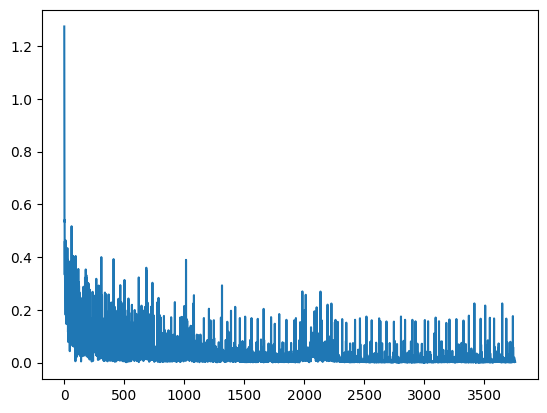

In [178]:
plt.plot(loss_vals)

In [179]:
dummy_model.eval()
y_pred = dummy_model(to_torch(X_test))
mse = loss_fn(y_pred.squeeze(), to_torch(y_test))
mse = float(mse)
np.sqrt(mse)

0.12440015619311655

In [180]:
for name,values in feature_extractor.named_parameters():
    print(name,": ", values)

linear1.weight :  Parameter containing:
tensor([[ 0.0685, -0.0170,  0.0585,  ..., -0.0565, -0.0836, -0.0886],
        [ 0.0016,  0.0734,  0.0040,  ..., -0.0638, -0.0833, -0.0535],
        [-0.0092, -0.0118,  0.0553,  ..., -0.0525,  0.0073, -0.0771],
        ...,
        [-0.0652,  0.0625, -0.0466,  ..., -0.0431,  0.0044,  0.0681],
        [-0.0189, -0.0004,  0.0270,  ..., -0.0118, -0.0050,  0.0177],
        [ 0.0315,  0.0816,  0.0678,  ..., -0.0636,  0.0167,  0.0346]],
       requires_grad=True)
linear1.bias :  Parameter containing:
tensor([ 1.3079e-01,  1.3545e-01, -9.1551e-03, -1.1516e-01, -5.9742e-02,
        -1.4904e-01,  6.4093e-02,  4.8827e-02,  1.2895e-01, -1.6786e-02,
        -6.1949e-02,  5.5359e-02, -1.3411e-01, -1.3914e-01, -1.3959e-02,
         4.1725e-02, -5.7183e-02,  1.2599e-01, -9.0791e-02, -2.2027e-02,
        -6.8517e-02, -2.5689e-02, -8.4163e-02, -2.5399e-01, -3.6460e-02,
        -1.2530e-01, -1.7321e-01, -9.3334e-02, -2.2373e-01,  3.5139e-02,
         1.7181e-01,  5

In [181]:
class AdditiveWithProjectionGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, d, max_degree):
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.NewtonGirardAdditiveKernel(
            RBFKernel(ard_num_dims=d), 
            # gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d)),
            #     num_dims=d, grid_size=100),
            # d, 
            max_degree,
        )
            
        self.feature_extractor = feature_extractor
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # This module will scale the NN features so that they're nice values
        self.max_degree = max_degree

    def forward(self, X):
        projected_X = self.feature_extractor(X)
        projected_X = self.scale_to_bounds(projected_X)  # Make the NN values "nice"

        mean = self.mean_module(projected_X)
        covar = self.covar_module(projected_X)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [182]:
likelihood = GaussianLikelihood()
max_degree = proj_dim   # if 1, it's GAM, and it's has already been done...
model = AdditiveWithProjectionGP(to_torch(X_train),to_torch(y_train),likelihood,proj_dim,max_degree)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 300
loss_vals = []
# iterator = tqdm.notebook.tqdm(range(training_iterations))
for i in tqdm(range(training_iterations)):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(to_torch(X_train))
    # Calc loss and backprop derivatives
    loss = -mll(output, to_torch(y_train))
    loss.backward()
    # iterator.set_postfix(loss=loss.item())
    optimizer.step()
    loss_vals.append(loss.item())
        


100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


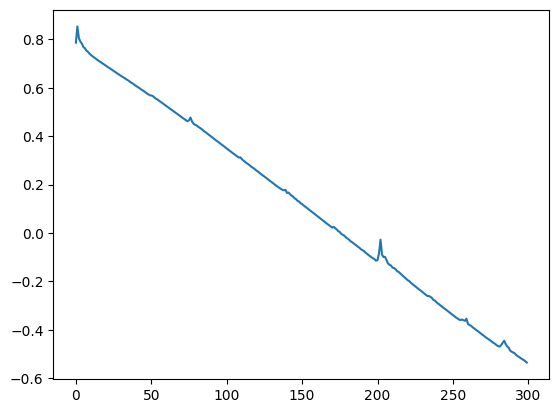

In [183]:
plt.plot(loss_vals)

In [184]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))

print(
    #     negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
    #   mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))


0.06912349


In [100]:
# likelihood = GaussianLikelihood()
# model = AdditiveWithProjectionGP(to_torch(X_train),to_torch(y_train),likelihood,proj_dim,max_degree)
# for param_name, param in model.named_parameters():
#     print(f'Parameter name: {param_name:42} value = {param}')

In [101]:
# likelihood = GaussianLikelihood()
# model = AdditiveWithProjectionGP(to_torch(X_train),to_torch(y_train),likelihood,proj_dim,max_degree)
# for param_name, param in model.named_parameters():
#     print(f'Parameter name: {param_name:42} value = {param}')